In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
from vpython import *
import cv2

In [42]:
%load_ext autoreload
%autoreload 2
import HEAD_RECON

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
head = HEAD_RECON.threeD_head.read_from_file(1,5)

In [4]:
head.center()
head.create_vpython_spheres()
head.save()

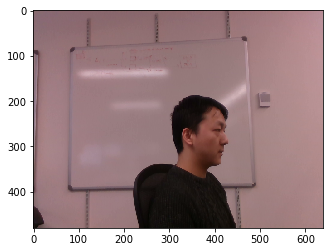

In [5]:
plt.imshow(head.twoD_image)
plt.show()

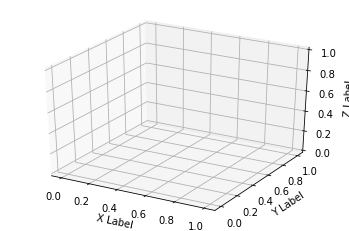

In [6]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

ax.scatter(head.xyz[:,0], -head.xyz[:,2], -head.xyz[:,1], c=head.rgb)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [43]:
for i in range(3,5):
    head1 = HEAD_RECON.threeD_head.read_from_file(1,i)
    head1.full_filter()
    head1.create_vpython_spheres()
    head1.save()

depth filter done.
dangling removal done
color filter done.
depth filter done.
dangling removal done
color filter done.


In [8]:
img1,path1 = head1.get_filtered_image()

In [9]:
head1 = HEAD_RECON.threeD_head.read_from_file(1,7)
head2 = HEAD_RECON.threeD_head.read_from_file(1,8)

In [40]:
head1 = HEAD_RECON.threeD_head.load_from_pickle(1,3)
head2 = HEAD_RECON.threeD_head.load_from_pickle(1,4)


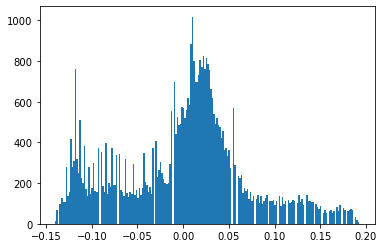

In [36]:
plt.hist(head2.xyz[:,2], bins=200)
plt.show()

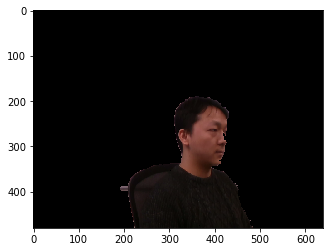

In [37]:
img1,path1 = head2.get_filtered_image()
plt.imshow(img1)

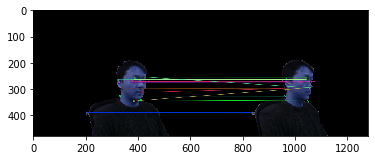

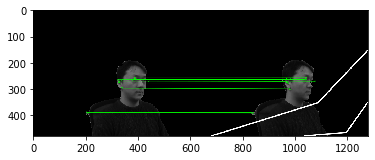

[[-0.05982537 -0.17069174  0.0413449 ]
 [-0.05658237 -0.15750174  0.0343449 ]
 [-0.05658237 -0.15750174  0.0343449 ]
 [-0.05162237 -0.14764074  0.0303449 ]
 [-0.03884137 -0.17034474  0.0133449 ]
 [-0.03651037 -0.11575874  0.0293449 ]
 [ 0.02512163 -0.17372974 -0.0236551 ]
 [ 0.04133463 -0.18483174 -0.0216551 ]
 [ 0.04108863 -0.17532574 -0.0236551 ]
 [ 0.40125363 -0.09603874  1.3173449 ]]
[[-0.03186778 -0.15972159  0.03167695]
 [-0.03186778 -0.14327559  0.03167695]
 [-0.03186778 -0.14327559  0.03167695]
 [-0.02370778 -0.13518859  0.02967695]
 [-0.00655178 -0.16059159  0.01167695]
 [-0.00921378 -0.09969859  0.02367695]
 [ 0.06685522 -0.15983659 -0.00732305]
 [ 0.08612822 -0.16886559  0.00567695]
 [ 0.08627222 -0.15920459  0.00667695]
 [ 0.41713122 -0.07059659  1.37867695]]


In [38]:
import multi_head

heads = multi_head.MultiHead.joined_heads(head1, head2)

In [39]:
heads.icp_transform(0,1)

step:  0 before:  0.6034149491747146
found the best fit transform 0
step:  1 before:  0.3730766506771485
found the best fit transform 1
icp processing done.


In [22]:
heads.save_spheres()

In [59]:
A=head1.xyz
B=head2.xyz

A.shape
filter =np.random.choice(np.arange(A.shape[0]),20)
A=A[filter]
from sklearn.neighbors import NearestNeighbors
NearestNeighbors(A.T, B.T)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None,
                 n_neighbors=array([[ 0.02810687,  0.00839587,  0.16342287,  0.07528787, -0.16578213,
         0.12215287, -0.20081713,  0.02225587, -0.07947913, -0.04849613,
         0.01976387, -0.22619713,  0.04745987,  0.23432787,  0.19649587,
        -0.02634113, -0.09519113, -0.08574213, -0.01836413,  0.03511087],
       [-0...
        -0.06138162,  0.00061838, -0.02838162, -0.00638162, -0.02138162,
         0.02461838,  0.04861838, -0.04938162, -0.06738162,  0.02661838]]),
                 p=2,
                 radius=array([[-0.04827324, -0.04653134, -0.0461922 , ...,  0.27637463,
         0.27922059,  0.28207246],
       [-0.30455608, -0.30463766, -0.30367615, ...,  0.17961492,
         0.18025286,  0.18088951],
       [ 0.06764277,  0.06732256,  0.05493934, ..., -0.00370364,
        -0.00215475, -0.00060697]]))

In [ ]:
img1,path1 = head1.get_filtered_image()
img2,path2 = head2.get_filtered_image()

In [ ]:
plt.imshow(head1.twoD_image)

In [ ]:
# test
kp1, des1 = HEAD_RECON.estimate_frame_transform.get_descriptors(path1)
kp2, des2 = HEAD_RECON.estimate_frame_transform.get_descriptors(path2)
good_without_list = HEAD_RECON.estimate_frame_transform.get_matched_points(path1,kp1,des1,path2,kp2,des2,0.8)


In [ ]:
cleaned_match = HEAD_RECON.estimate_frame_transform.clean_matches(kp1,path1,kp2,path2,good_without_list)

In [ ]:
import multi_head

heads = multi_head.MultiHead.joined_heads(head1, head2)

print(head1.center_pos)
print(head2.center_pos)

In [ ]:
%matplotlib inline

test_img= (head1.twoD_image.copy())
plt.imshow(test_img)
plt.scatter(xy1[:,0],xy1[:,1])
plt.show()


In [ ]:
%matplotlib inline
test_img= (head2.twoD_image.copy())
plt.imshow(test_img)
plt.scatter(xy2[:,0],xy2[:,1],c='g')
plt.show()


In [ ]:
from Procustes import *
A = head1.xyz_unfiltered[xyindex1][1:]
B = head2.xyz_unfiltered[xyindex2][1:]
print('----\n',A)
print('----\n',B)

c, R, t = umeyama(A, B)    
print ('c', c)
print ('R', R)
print ('t', t)

print('-------')
print('-------')
print('-------')
print(B.dot(c*R)+t)
print('-------')
print(A)

In [ ]:
d, Z, tform= procrustes(A, B, scaling=True, reflection='best')

R,c,t = tform['rotation'], tform['scale'], tform['translation']


print ("Check:  B*cR + t = A  is", np.allclose(B.dot(c*R) + t, A))
err = ((B.dot(c * R) + t - A) ** 2).sum()
print ("Residual error", err)

B.dot(c*R) + t

In [ ]:
dst_pts

In [ ]:
from Procrustes2 import *
A = np.array([
  [0, 0, -1],
  [0, 0, 0],
  [0, 0, 1],
  [0, 1, 0],
  [0, 1, 0],
  [1, 0, 0],
])

B = np.array([
  [0, 0, 1],
  [0, 0, 0],
  [0, 0, -1],
  [0, 1, 0],
  [0, 1, 0],
  [-1, 0, 0],
])

In [ ]:
d, Z, tform= procrustes(A, B, scaling=True, reflection='best')

R,c,t = tform['rotation'], tform['scale'], tform['translation']



print ("Check:  B*cR + t = A  is", np.allclose(B.dot(c*R) + t, a1))
err = ((B.dot(c * R) + t - A) ** 2).sum()
print ("Residual error", err)

In [ ]:
R

In [ ]:
from Procrustes2